In [2]:
from scipy.optimize import minimize
from optimization_func import simulated_annealing
import numpy as np
from scipy import stats
import multiprocessing as mp
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl

from helper import get_predator_prey_data, mse_trunc, \
    remove_data_points_rand, remove_data_points_det, int_cost_lotka_volterra
from workers import vary_truncation_worker

t, P = get_predator_prey_data()

In [3]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [4]:
def get_n_removed_points(d):
    return len(np.argwhere(d.flatten() == -1))

def trunc_cost(*args):
    return int_cost_lotka_volterra(*args, cost=mse_trunc)

def generate_truncated_datasets(P, n, max_points, col):
    p = P.copy()
    Ps = [p]
    for i in range(max_points//n):
        p = remove_data_points_det(p.copy(), n, col=col)
        Ps.append(p)
    return Ps

In [5]:
def vary_truncation(trunc_datasets, P, t, rv, n_sim=100, T_start=200, T_steps=2000):
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(trunc_datasets)):
        results.append(manager.list())
        for j in range(n_sim):
            work_queue.put((i, j))

    processes = []

    for i in range(10):
        p = mp.Process(target=vary_truncation_worker, args=(
            work_queue, results, T_start, T_steps, P, t, rv, trunc_datasets
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(t) for t in results], trunc_datasets

In [6]:
%%time
if False:
    with shelve.open("Arrays/data_removal") as shelf:
        n = 5            # number of points to remove every time
        max_points = 100 # max number of points to remove. if not divisible by n, will floor down
        n_sim = 100

        t, P = get_predator_prey_data()

        np.random.seed(74545)
        
        # truncate x timeseries
        trunc_datasets_x = generate_truncated_datasets(P, n, max_points, 0)
        print([get_n_removed_points(p) for p in trunc_datasets_x])
        rv = [1, 1, 1, 1]

        costs_x, datasets_x = vary_truncation(trunc_datasets_x, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_x"] = costs_x
        shelf["datasets_x"] = datasets_x

        # truncate y timeseries
        trunc_datasets_y = generate_truncated_datasets(P, n, max_points, 1)
        print([get_n_removed_points(p) for p in trunc_datasets_y])

        costs_y, datasets_y = vary_truncation(trunc_datasets_y, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_y"] = costs_y
        shelf["datasets_y"] = datasets_y

        shelf.close()

Wall time: 0 ns


In [7]:
#Open data
shelf = shelve.open("Arrays/data_removal")
costs_x = shelf["data_removal_costs_x"] 
datasets_x = shelf["datasets_x"]

costs_y = shelf["data_removal_costs_y"] 
datasets_y = shelf["datasets_y"] 
shelf.close() 

In [8]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

10.153054769045958
[3.96912590e+00 4.78185698e+00 4.75702342e+00 4.42266208e+00
 5.13791069e+00 4.16428567e+00 6.72027786e+00 6.12407438e+00
 1.16236652e+01 1.30812553e+03 5.35630011e+02 4.70640726e+01
 1.80086074e+02 8.00510229e+03 4.75118957e+05 2.83421614e+05
 2.17128396e+04 9.89376158e+02 2.58940340e+02 7.16181885e+02
 9.58424337e+02]
[3.31534093 4.53335722 3.99393405 3.56625274 3.56843796 3.7239429
 3.72786458 3.82066558 4.16067995 3.80427859 4.29238837 4.38089584
 3.60709035 3.25282642 3.83839278 4.47590865 3.93876325 4.82293743
 5.59961142 6.89761172 9.72428652]


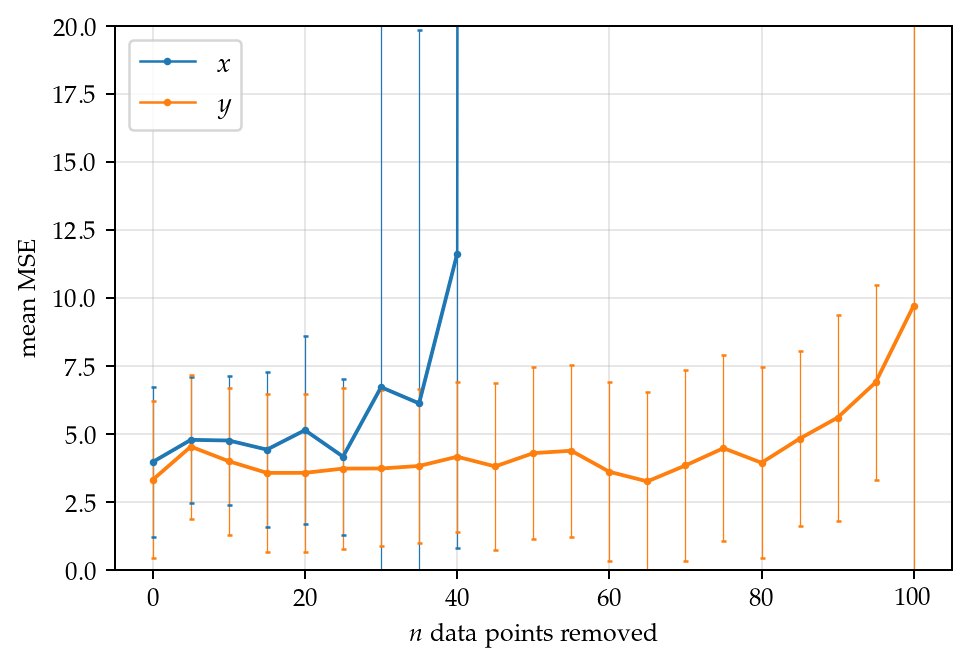

In [14]:
datasets = [datasets_x, datasets_y]
costs = [costs_x, costs_y]
colors = ["tab:blue", "tab:orange"]
original_MSE = int_cost_lotka_volterra([1, 1, 1, 1], P, t)
print(original_MSE)
for i in range(len(datasets)):
    mean = np.mean(costs[i], axis = 1)
    print(mean)
    min_ = np.min(costs[i], axis = 1)
    max_ = np.max(costs[i], axis = 1)
    x = [get_n_removed_points(p) for p in datasets[i]]
    std = np.std(costs[i], axis = 1)
    plt.plot(x, mean, marker="o", markersize = 2, linewidth=1, color = colors[i], label=f"{['$x$', '$y$'][i]}")
    if i == 0:
        plt.errorbar(x[:9], mean[:9], yerr=std[:9], color = colors[i], capsize = 1, elinewidth=0.5, markeredgewidth=1)
    else:
        plt.errorbar(x, mean, yerr=std, color = colors[i], capsize = 1, elinewidth=0.5, markeredgewidth=1)
plt.grid(alpha=0.3)
plt.ylabel("mean MSE")
plt.ylim(0, 20)
plt.xlabel("$n$ data points removed")
plt.legend()
plt.savefig("figures/Data_removal_mean.pdf", bbox_inches="tight")
plt.show()

10.153054769045958


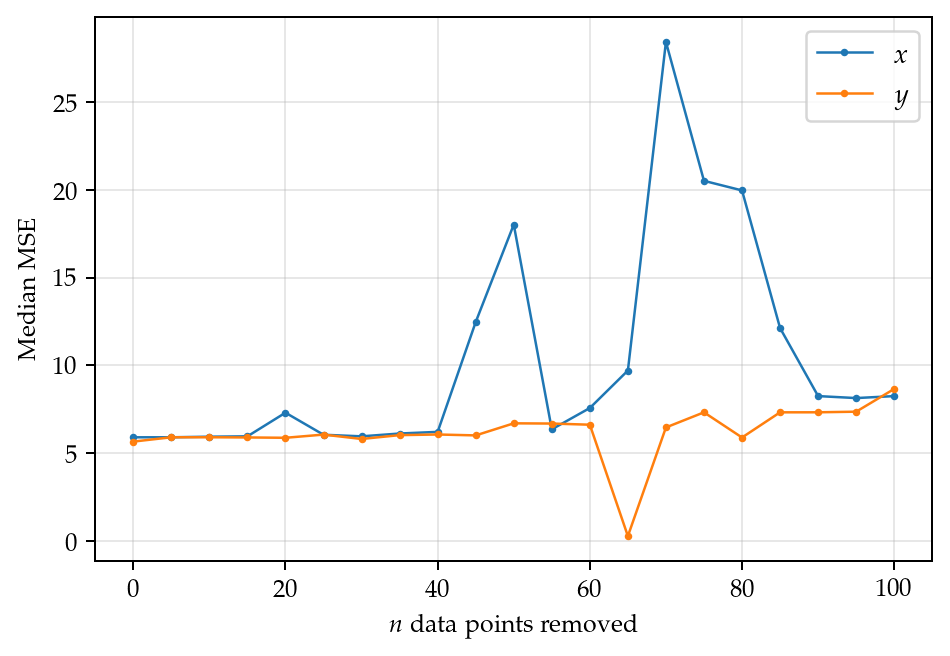

In [15]:
datasets = [datasets_x, datasets_y]
costs = [costs_x, costs_y]
colors = ["tab:blue", "tab:orange"]
original_MSE = int_cost_lotka_volterra([1, 1, 1, 1], P, t)
print(original_MSE)
for i in range(len(datasets)):
    median = np.median(costs[i], axis = 1)
    x = [get_n_removed_points(p) for p in datasets[i]]
    plt.plot(x, median, marker="o", markersize = 2, linewidth=1, color = colors[i], label=f"{['$x$', '$y$'][i]}")
plt.grid(alpha=0.3)
plt.ylabel("Median MSE")
plt.xlabel("$n$ data points removed")
plt.legend()
plt.show()

10.153054769045958


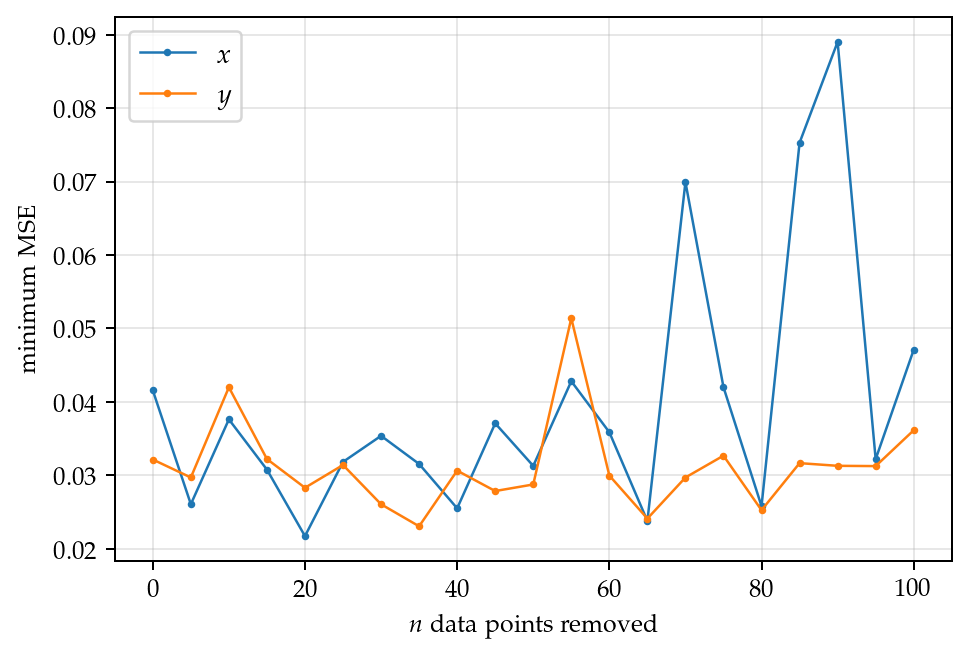

In [12]:
datasets = [datasets_x, datasets_y]
costs = [costs_x, costs_y]
colors = ["tab:blue", "tab:orange"]
original_MSE = int_cost_lotka_volterra([1, 1, 1, 1], P, t)
print(original_MSE)
for i in range(len(datasets)):
    min_ = np.min(costs[i], axis = 1)
    max_ = np.max(costs[i], axis = 1)
    x = [get_n_removed_points(p) for p in datasets[i]]
    plt.plot(x, min_, marker="o", markersize = 2, linewidth=1, color = colors[i], label=f"{['$x$', '$y$'][i]}")
plt.grid(alpha=0.3)
plt.ylabel("minimum MSE")
plt.xlabel("$n$ data points removed")
plt.legend()
plt.savefig("figures/Data_removal_min.pdf", bbox_inches="tight")
plt.show()

10.153054769045958


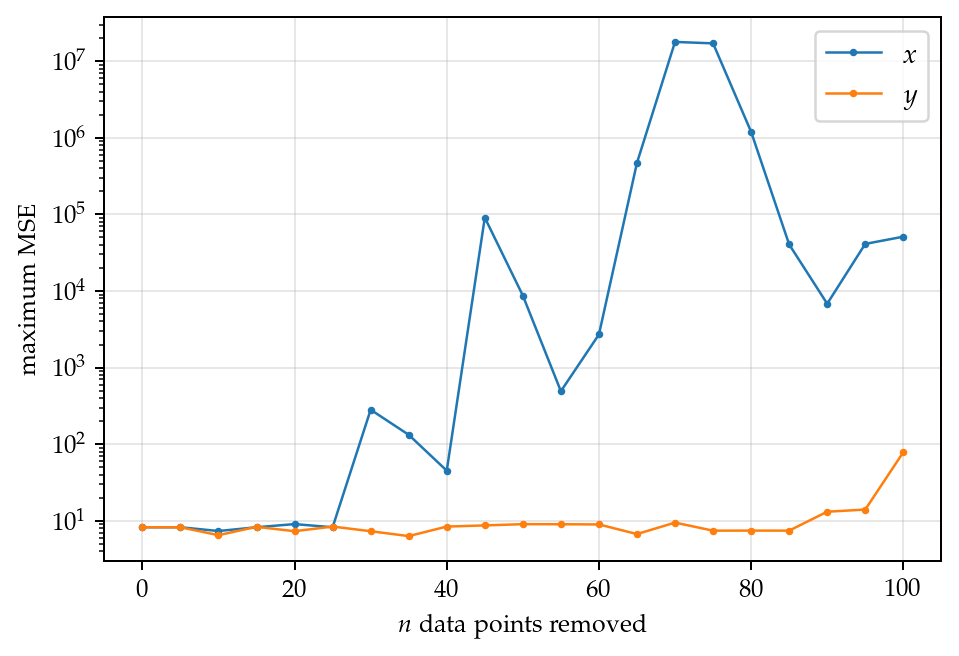

In [13]:
datasets = [datasets_x, datasets_y]
costs = [costs_x, costs_y]
colors = ["tab:blue", "tab:orange"]
original_MSE = int_cost_lotka_volterra([1, 1, 1, 1], P, t)
print(original_MSE)
for i in range(len(datasets)):
    max_ = np.max(costs[i], axis = 1)
    x = [get_n_removed_points(p) for p in datasets[i]]
    plt.plot(x, max_, marker="o", markersize = 2, linewidth=1, color = colors[i], label=f"{['$x$', '$y$'][i]}")
plt.grid(alpha=0.3)
plt.ylabel("maximum MSE")
plt.xlabel("$n$ data points removed")
plt.yscale("log")
plt.legend()
plt.savefig("figures/Data_removal_max.pdf", bbox_inches="tight")
plt.show()

### Combining of the datasets

In [77]:
np.random.seed(234234)

if False: 
    #Dataset with 25 points removed
    print(sum([x==-1 for x in datasets_x[5]]))
    #Dataset with 80 points removed
    print(sum([x==-1 for x in datasets_y[16]]))

    P_reduced = np.array([datasets_x[4][:,0], datasets_y[16][:,1]]).T
    N_sim = 100
    Results = []
    for i in range(N_sim):
        state, _, _ = simulated_annealing([1, 1, 1, 1], t, P_reduced, cost = mse_trunc, cooling_schedule="quadratic", T_start=200, T_steps=2000, eta = 0.2)
        MSE = int_cost_lotka_volterra(state, P, t)
        Results.append(MSE)
    
    shelf = shelve.open("Arrays/data_removal")
    shelf["costs_final_reduced_set"] = Results
    shelf.close()    

[25  0]
[ 0 80]


C:\Users\malou\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [4]:
shelf = shelve.open("Arrays/data_removal")
Final_trunc = shelf["costs_final_reduced_set"]
shelf.close()

In [5]:
print(np.mean(Final_trunc))
print(np.median(Final_trunc))
print(np.min(Final_trunc))
print(np.max(Final_trunc))

4.460413500374785
7.549144341277339
0.032837000285130015
7.887616666752664
